# Applied Machine Learning - CORAL Trial - Joshua Breidenbach

Hypothesis: "Patient demographics and routine clinical lab measures in a group of Atherosclerotic Renal-Artery Stenosis patients are sufficient for the prediction of serum paraoxonase (PON) activity."

## Initial Imports

In [4]:
#First, we import packages to be used in this workflow
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import keras #First need to install keras and tensorflow (pip install *)
from keras.models import Sequential
from keras.layers import Dense
import seaborn as sns
import matplotlib.pyplot as plt

## Preprocessing
### Import and clean data
#### Import
#### Remove unwanted features
#### Deal with missing data - remove feature and samples
#### Balance classes

In [5]:
#Then, we read in our original data
Original_Data = pd.read_csv(r"C:\Users\Josh\Downloads\CORAL_Baseline_V3.csv", index_col ='Analysis Sequence')
Original_Data.shape

(718, 44)

In [6]:
#Let's first remove features that may not be of interest to us
Cleaned_df = Original_Data.drop(columns=['Sub ID', 
                                         'HDL Baseline Median High_Low', 
                                         'LDL Baseline Median High_Low', 
                                         'Microalbumin Cr Ratio Log Bsln.', 
                                         'SPECIFIC PON ACTIVITY (pmol/min/mL) Baseline', 
                                         'PON Activity Baseline Median High_Low', 
                                         'PON_HDL Ratio Baseline',
                                         'LDL_PON Ratio Baseline'
                                        ])
Cleaned_df.shape

(718, 36)

In [7]:
#Let's take a better look at our data and identify missing values
display(Cleaned_df.describe())

,Age,Height (ins),Weight (lbs),BMI,SBP Baseline,DBP Baseline,UACR Baseline,Creatinine Baseline,Cystatin C Baseline,Potassium Baseline,HDL Baseline mg/dL,LDL Baseline mg/dL,Total HTN Class Drugs Baseline,Total Meds Overall Baseline
count,718.000000,717.000000,717.000000,716.000000,717.000000,717.000000,665.000000,715.000000,715.000000,651.000000,712.000000,698.000000,716.000000,716.000000
mean,69.495822,65.875872,176.737796,29.455712,149.238494,78.393305,191.453128,1.242811,1.270601,4.169877,43.018258,93.100287,2.002793,3.828212
std,9.320086,4.125807,42.484383,5.713399,22.820658,12.976724,689.750614,0.455655,0.460336,0.577996,12.823960,59.785136,1.455155,2.497515
min,19.000000,48.000000,83.000000,14.160000,88.000000,37.000000,1.470000,0.460000,0.270000,2.700000,15.000000,12.000000,0.000000,0.000000
25%,63.000000,63.000000,150.000000,25.860000,133.000000,71.000000,9.090000,0.910000,0.950000,3.800000,34.000000,68.000000,1.000000,2.000000
50%,70.000000,66.000000,175.000000,28.510000,149.000000,78.000000,20.830000,1.170000,1.180000,4.100000,41.000000,83.000000,2.000000,4.000000
75%,76.000000,69.000000,198.000000,32.540000,163.000000,87.000000,75.360000,1.495000,1.470000,4.500000,49.000000,108.000000,3.000000,6.000000
max,89.000000,81.000000,786.000000,63.820000,227.000000,133.000000,7812.500000,4.010000,3.790000,8.500000,93.000000,1136.000000,6.000000,11.000000


In [8]:
'''

Let's see how many values are missing for each feature.

'''
np.sum(Cleaned_df.isna()) #Displays number of missing values in each feature (#of NaN)

Age                                0
Sex                                0
Race                               0
Ethnicity: Latino_Hispanic         0
Height (ins)                       1
Weight (lbs)                       1
BMI                                2
Treatment_Assignment               0
Creatinine Status                  0
Site_Country Group                 0
SBP Baseline                       1
DBP Baseline                       1
UACR Baseline                     53
CKD by CKD_EPI Calc                3
CKD by CKD_EPI                     3
CKD                                2
CKD Stage                          0
CKD Stage by CKD_EPI GFR           3
Renal Dysfunction                  4
DM                                 4
Creatinine Baseline                3
Cystatin C Baseline                3
Potassium Baseline                67
HDL Baseline mg/dL                 6
LDL Baseline mg/dL                20
Angina                            79
TIA | Stroke                       8
C

In [9]:
'''
We need to remove samples or sample features with missing values
Alternatively, we may impute missing values
First, let's find out how many samples we will remove if we remove ones which have atleast 1 missing value

'''
data_dropped = Cleaned_df.dropna() #Drops samples (rows) which have missing data
display(Cleaned_df.shape) #Displays original data shape (rows, columns)
display(data_dropped.shape) #Displays trimmed data shape

(718, 36)

(482, 36)

In [10]:
'''
Then, let's find out how many samples we will remove if we first remove features with many missing values such as 'Potassium Baseline', 'Angina', 'CVD'

'''
FeaturesDropped_df = Cleaned_df.drop(columns=['Potassium Baseline', 'Angina', 'CVD'])
display(FeaturesDropped_df.shape) #Confirm that columns have been dropped
newdata_dropped = FeaturesDropped_df.dropna() #Drops samples (rows) which have missing data
display(Cleaned_df.shape) #Displays original data shape (rows, columns)
display(data_dropped.shape) #Displays trimmed data shape
display(newdata_dropped.shape) #Displays trimmed data shape

(718, 33)

(718, 36)

(482, 36)

(614, 33)

In [11]:
'''
We see that when we remove the features with large numbers of missing values, 'Potassium Baseline', 'Angina', and 'CVD', we can preserve more of our samples.
Here we are only losing 14.4% of our samples instead of 32.8%.
If this is still inadequate, we could come back to this step and attempt different methods of imputation.
Next, we want to check the balance of our data between the 2 classes 'High' or 'Low' stored currently in the PONClass column of newdata_dropped.

'''
np.sum(newdata_dropped['PONClass']=='High'), np.sum(newdata_dropped['PONClass']=='Low')

(567, 47)

In [76]:
'''
We see that our data is very imbalanced, with Low only being represented by about 7% of our data.
To address this, we can undersample from the majority 'High'.
'''
minority = newdata_dropped[newdata_dropped['PONClass'] == 'Low'] #Assigns the Low PONClass samples to the minority df
majority = newdata_dropped[newdata_dropped['PONClass'] == 'High'] #Assigns the High PONClass samples to the majority df

undersampled = resample(majority, n_samples=47, random_state=509) #Randomly selects samples from the majority df until there are a total of 47 samples with 'High'

newdata_balanced = pd.concat([undersampled,minority]) #Combines the 47 randomly selected majority samples with the 47 minority samples
newdata_balanced.shape #Confirm that new rows have been added (47 *2 rows)

(94, 33)

In [77]:
'''
Because this is a labeled dataset, we need to remove our classifier from the data.

'''
target = newdata_balanced['PONClass']
newdata = newdata_balanced.drop(columns=['PONClass'])

'''
'target' still contains strings and should be converted to numerical category codes.
This will be done by label encoding.
This results in 'High' -> 0 and 'Low' -> 1.

'''

labelencoder = LabelEncoder()
target = labelencoder.fit_transform(target)
newdata.shape #Confirm that a column has been removed

(94, 32)

In [78]:
'''
Now that there are no missing values in our data and our class labels have been set aside, we need to deal with our categorical variables.
We'll use a panda dummmies method to convert each category of each categorical variable to it's own binary column.
More info on this method can be found here: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

'''
newdata_dum = pd.get_dummies(newdata, 
                        columns=["Sex","Race", "Ethnicity: Latino_Hispanic", "Treatment_Assignment", "Creatinine Status", "Site_Country Group", "CKD by CKD_EPI Calc", "CKD by CKD_EPI", "CKD", "CKD Stage", "CKD Stage by CKD_EPI GFR", "Renal Dysfunction", "DM", "TIA | Stroke", "CHF Hx", "Hyperlipidemia", "Smoking", "MI", "PVD"], 
                        prefix=["Sex_is","Race_is", "Hispanic_is", "Treatment_is", "Creatinine_Status_is", "Site_is", "CKD_by_EPI_Calc_is", "CKD_by_EPI_is", "CKD_is", "CKD_Stage_is", "CKD_Stage_by_CKD_EPI_GFR_is", "Renal_Dysfunction_is", "DM_is", "TIA_or_Stroke_is", "CHF_Hx_is", "Hyperlipidemia_is", "Smoking_is", "MI_is", "PVD_is"] 
                       )
newdata_dum.shape

(94, 58)

### Scaling

In [52]:
class Preprocessing:
    def __init__(self, data):
        self.data = data
        
    def scale(self):
        #Used to scale the data to the space between 0 and 1
        data_to_be_scaled = self.data
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data_to_be_scaled)
        return scaled_data

In [79]:
#Now that our data is cleaned and our target is defined, let's finish the preprocessing of our data
OGdata = Preprocessing(newdata_dum)
OGdata.scale()

array([[0.61538462, 0.51724138, 0.58125   , ..., 1.        , 0.        ,
        1.        ],
       [0.74358974, 0.5862069 , 0.44375   , ..., 1.        , 1.        ,
        0.        ],
       [0.        , 0.44827586, 0.2625    , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.33333333, 0.48275862, 0.41875   , ..., 0.        , 1.        ,
        0.        ],
       [0.61538462, 0.27586207, 0.0875    , ..., 0.        , 1.        ,
        0.        ],
       [0.74358974, 0.62068966, 0.5125    , ..., 1.        , 0.        ,
        1.        ]])

## Supervised Machine Learning
### SVM

In [18]:
class SVM: 
    
    def __init__(self, scaled_data, target, unscaled_data):
        self.data = scaled_data
        self.target = target
        self.unscaled_data = unscaled_data
        self.svm_model = SVC(kernel='linear') #Defines model
        
    def fit_and_predict(self):        
        skf = StratifiedKFold(n_splits=5) #5 is used because an 80/20 or 70/30 split is a typical split
        self.all_feature_importances = np.zeros((len(set(self.target)),len(self.unscaled_data.columns)))
        self.all_labels = [] #used to keep track of labels corresponding to predicitons
        self.all_predictions = [] #used to keep track of predicitons
        self.accuracy = 0
        
        for train_index, test_index in skf.split(self.data, self.target): #performs the train test splits
            X_train, y_train = self.data[train_index], self.target[train_index]
            X_test, y_test = self.data[test_index], self.target[test_index]
            self.svm_model.fit(X_train,y_train) #fits the model to the training data
            self.all_feature_importances += self.svm_model.coef_ #records feature importances
            self.predictions = self.svm_model.predict(X_test) #predicts labels of test data
            self.all_predictions.extend(self.predictions) #records predictions
            self.all_labels.extend(y_test)#records corresponding labels
            self.accuracy += accuracy_score(self.predictions,y_test)#records accuracy
        
        print("PREDICTION ACCURACY")
        print(self.accuracy/5)#divide accuracy by 5 to get average of all stratified k-fold splits
        print()
        print('ALL LABELS')
        print(self.all_labels)
        print()
        print('ALL PREDICTIONS')
        print(self.all_predictions)
        
    def cm(self):
        self.cm = confusion_matrix(self.all_labels,self.all_predictions,normalize= 'true')#loads label and prediction data into confusion matrix
        df_cm = pd.DataFrame(self.cm,index=[0,1],columns=[0,1])
        sns.heatmap(df_cm, annot=True)
        
    def feature_importance(self):
        average_feature_importances = []
        for i in range(self.all_feature_importances.shape[1]):
            average_value = 0
            for array in self.all_feature_importances:
                average_value += abs(array[i])
            average_feature_importances.append(average_value/5)#divide by 5 because of K-fold splits
            
        plt.figure(figsize = (15,10))
        plt.bar(list(self.unscaled_data.columns),average_feature_importances, color ='maroon',  width = 0.4, ) 
        plt.xticks(rotation=90)
        plt.title('Feature Importances')

PREDICTION ACCURACY
0.6187134502923977

ALL LABELS
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

ALL PREDICTIONS
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]


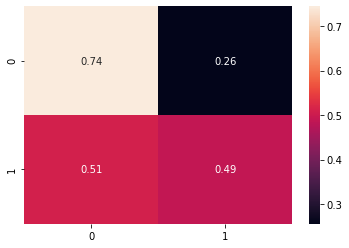

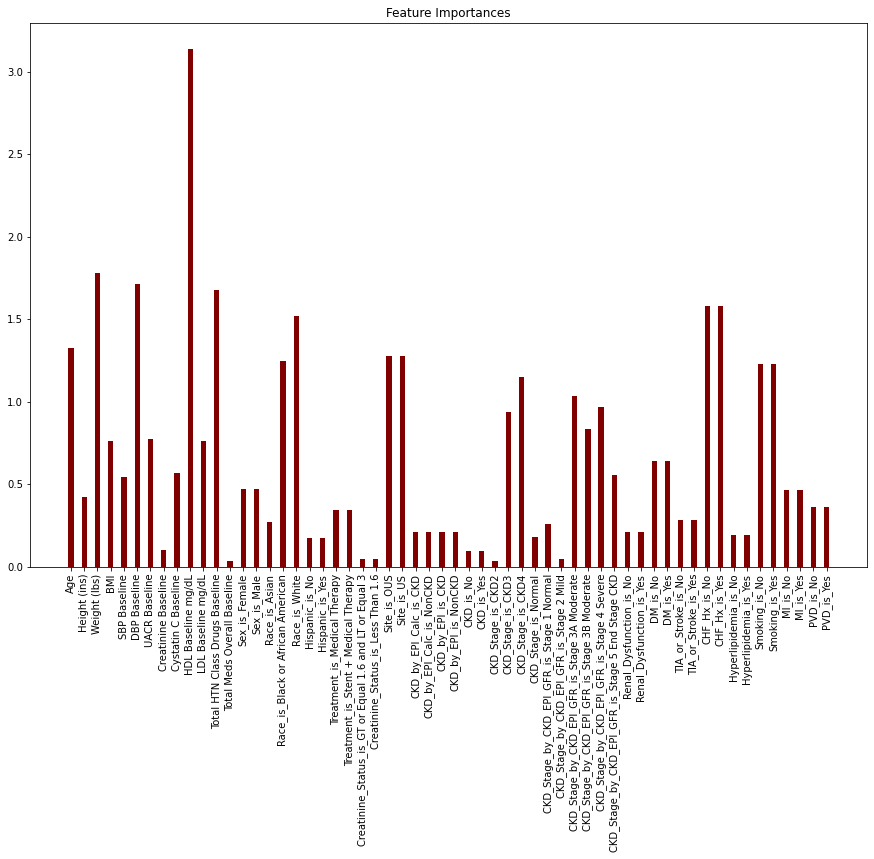

In [19]:
svm_model = SVM(OGdata.scale(), target, newdata_dum) #Build SVM model
svm_model.fit_and_predict() #Fit and predict with this model
svm_model.cm() #Produce confusion matrix
svm_model.feature_importance() #Produce feature importance plot

### Random Forest Model
#### All Features

In [21]:
class RFC: #Random Forest Classifier
    
    def __init__(self, scaled_data, target, unscaled_data, trees):
        self.data = scaled_data
        self.target = target
        self.unscaled_data = unscaled_data
        self.trees = trees #number of trees in forest
        self.rfclf=RandomForestClassifier(n_estimators=self.trees) # Instantiate model with 100 decision trees
        
    def fit_and_predict(self):        
        skf = StratifiedKFold(n_splits=5) #5 is used because an 80/20 or 70/30 split is a typical split
        self.all_feature_importances = np.zeros((len(set(self.target)),len(self.unscaled_data.columns)))
        self.all_labels = [] #used to keep track of labels corresponding to predicitons
        self.all_predictions = [] #used to keep track of predictions
        self.accuracy = 0 
        
        for train_index, test_index in skf.split(self.data, self.target):#Performs train test splits
            X_train, y_train = self.data[train_index], self.target[train_index]
            X_test, y_test = self.data[test_index], self.target[test_index]
            
            self.rfclf.fit(X_train, y_train) #fit the model to the training data
            
            self.all_feature_importances += self.rfclf.feature_importances_ #record feature importances
            
            self.predictions = self.rfclf.predict(X_test) #predict from text data
            self.all_predictions.extend(self.predictions) #record predictions
            
            self.all_labels.extend(y_test) #record matching labels
            self.accuracy += metrics.accuracy_score(y_test, self.predictions) #calculate accuracy
        
        print("PREDICTION ACCURACY")
        print(self.accuracy/5)#divided by 5 to average across k-fold splits
        print()
        print('ALL LABELS')
        print(self.all_labels)
        print()
        print('ALL PREDICTIONS')
        print(self.all_predictions)
        
    def cm(self):
        self.cm = confusion_matrix(self.all_labels,self.all_predictions,normalize= 'true')#loads label and prediction data into confusion matrix
        df_cm = pd.DataFrame(self.cm,index=[0,1],columns=[0,1])
        sns.heatmap(df_cm, annot=True)
        
    def feature_importance(self):
        average_feature_importances = []
        for i in range(self.all_feature_importances.shape[1]):
            average_value = 0
            for array in self.all_feature_importances:
                average_value += abs(array[i])
            average_feature_importances.append(average_value/5)#divide by 5 because of K-fold splits
            
        plt.figure(figsize = (15,10))
        plt.bar(list(self.unscaled_data.columns),average_feature_importances, color ='maroon',  width = 0.4, ) 
        plt.xticks(rotation=90)
        plt.title('Feature Importances')

PREDICTION ACCURACY
0.6187134502923977

ALL LABELS
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

ALL PREDICTIONS
[0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


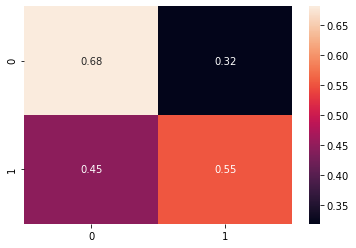

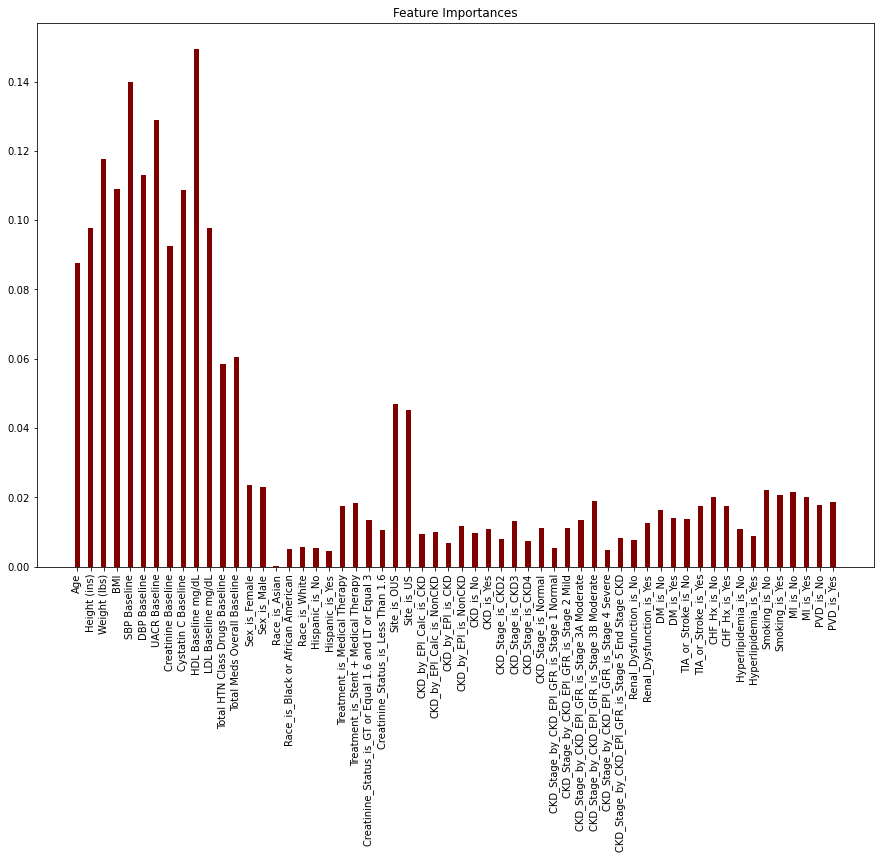

In [89]:
RF = RFC(OGdata.scale(), target, newdata_dum, 100) #Build Random Forest with 100 trees
RF.fit_and_predict() #Fit and predict with this model
RF.cm() #Produce confusion matrix
RF.feature_importance() #Produce feature importance plot

### Random Forest Model
#### Slimmed dataset (most important features by SVM and RF models)

In [90]:
'''
Because not all features are important for the prediction, 
let's try only using some of the more important features from the dataset and retesting the prediction accuracy with RFC.

'''
columns_to_keep_RF = newdata[['Age', 
                           'Height (ins)', 
                           'Weight (lbs)',
                           'BMI', 
                           'SBP Baseline',
                           'DBP Baseline',
                           'UACR Baseline', 
                           'Creatinine Baseline', 
                           'Cystatin C Baseline', 
                           'HDL Baseline mg/dL', 
                           'LDL Baseline mg/dL',
                           'Total HTN Class Drugs Baseline',
                           'Total Meds Overall Baseline'
                          ]]
slim_df = columns_to_keep_RF.copy()

#Now that our data is cleaned and our target is defined, let's finish the preprocessing of our data
slim_df_scaled = Preprocessing(slim_df)
slim_df_scaled.scale()

array([[0.61538462, 0.51724138, 0.58125   , ..., 0.29059829, 0.        ,
        0.        ],
       [0.74358974, 0.5862069 , 0.44375   , ..., 0.44444444, 0.8       ,
        0.8       ],
       [0.        , 0.44827586, 0.2625    , ..., 0.57264957, 0.        ,
        0.        ],
       ...,
       [0.33333333, 0.48275862, 0.41875   , ..., 0.36752137, 0.2       ,
        0.2       ],
       [0.61538462, 0.27586207, 0.0875    , ..., 0.08547009, 0.6       ,
        0.5       ],
       [0.74358974, 0.62068966, 0.5125    , ..., 0.58119658, 0.        ,
        0.1       ]])

PREDICTION ACCURACY
0.5742690058479532

ALL LABELS
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

ALL PREDICTIONS
[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1]


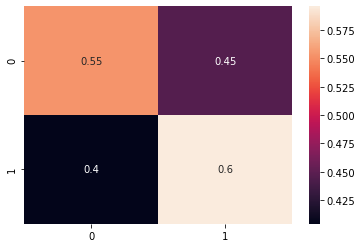

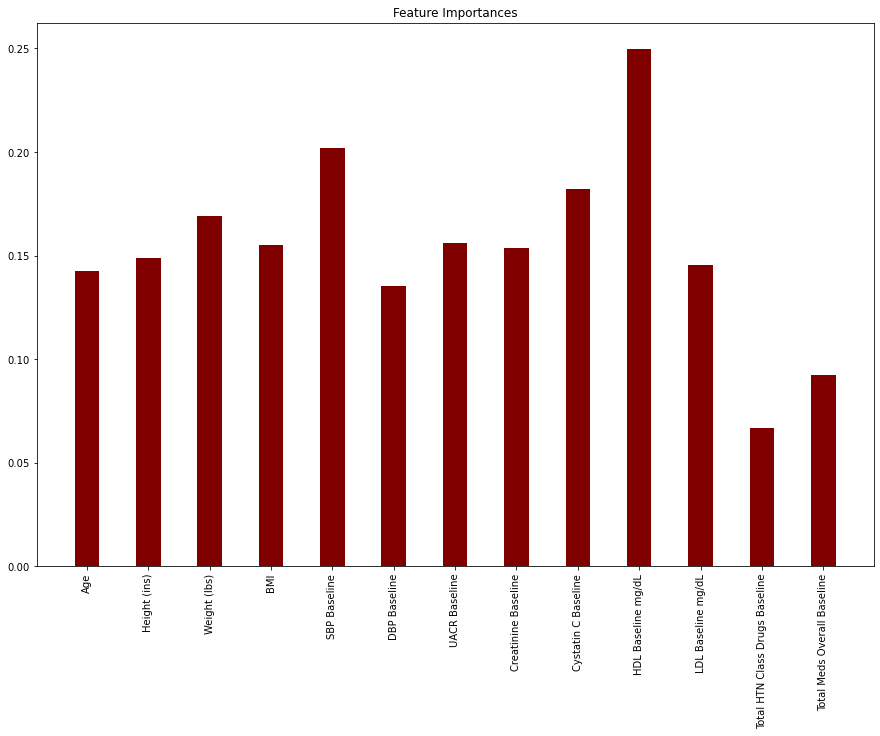

In [91]:
slim_df_RF = RFC(slim_df_scaled.scale(), target, slim_df, 25) #Build Random Forest with 25 trees for slim df
slim_df_RF.fit_and_predict() #Fit and predict with this model
slim_df_RF.cm() #Produce confusion matrix
slim_df_RF.feature_importance() #Produce feature importance plot

### Random Forest Regression Model
#### All Features

In [26]:
'''
I'm curious about the ability for a random forest regression model to predict the PON activity numerical value.
We'll have to essentially start back from the beginning and keep our variable 'SPECIFIC PON ACTIVITY (pmol/min/mL) Baseline'
and remove 'PONClass'

'''
Original_Data2 = pd.read_csv(r"C:\Users\Josh\Downloads\CORAL_Baseline_V3.csv", index_col ='Analysis Sequence')
#Let's first remove features that may not be of interest to us
Quant_Cleaned_df = Original_Data2.drop(columns=['Sub ID', 
                                         'HDL Baseline Median High_Low', 
                                         'LDL Baseline Median High_Low', 
                                         'Microalbumin Cr Ratio Log Bsln.',  
                                         'PON Activity Baseline Median High_Low', 
                                         'PON_HDL Ratio Baseline',
                                         'LDL_PON Ratio Baseline'
                                        ])
Quant_FeaturesDropped_df = Quant_Cleaned_df.drop(columns=['Potassium Baseline', 'Angina', 'CVD'])
Quant_newdata_dropped = Quant_FeaturesDropped_df.dropna() #Drops samples (rows) which have missing data
'''
We know that our data is very imbalanced, with Low only being represented by about 7% of our data.
To address this, we can undersample from the majority 'High'.

'''
Quant_minority = Quant_newdata_dropped[Quant_newdata_dropped['PONClass'] == 'Low'] #Assigns the Low PONClass samples to the minority df
Quant_majority = Quant_newdata_dropped[Quant_newdata_dropped['PONClass'] == 'High'] #Assigns the High PONClass samples to the majority df

Quant_undersampled = resample(Quant_majority, n_samples=47, random_state=509) #Randomly selects samples from the majority df until there are a total of 47 samples with 'High'

Quant_newdata_balanced = pd.concat([Quant_undersampled,Quant_minority]) #Combines the 47 randomly selected majority samples with the existing 47 minority samples

'''Now we need to separate the target from the data and scale'''

Quant_target = Quant_newdata_balanced['SPECIFIC PON ACTIVITY (pmol/min/mL) Baseline']
Quant_newdata = Quant_newdata_balanced.drop(columns=['SPECIFIC PON ACTIVITY (pmol/min/mL) Baseline', 'PONClass'])
Quant_newdata_dum = pd.get_dummies(Quant_newdata, 
                        columns=["Sex","Race", "Ethnicity: Latino_Hispanic", "Treatment_Assignment", "Creatinine Status", "Site_Country Group", "CKD by CKD_EPI Calc", "CKD by CKD_EPI", "CKD", "CKD Stage", "CKD Stage by CKD_EPI GFR", "Renal Dysfunction", "DM", "TIA | Stroke", "CHF Hx", "Hyperlipidemia", "Smoking", "MI", "PVD"], 
                        prefix=["Sex_is","Race_is", "Hispanic_is", "Treatment_is", "Creatinine_Status_is", "Site_is", "CKD_by_EPI_Calc_is", "CKD_by_EPI_is", "CKD_is", "CKD_Stage_is", "CKD_Stage_by_CKD_EPI_GFR_is", "Renal_Dysfunction_is", "DM_is", "TIA_or_Stroke_is", "CHF_Hx_is", "Hyperlipidemia_is", "Smoking_is", "MI_is", "PVD_is"] 
                       )
Quant_df_scaled = Preprocessing(Quant_newdata_dum)
Quant_df_scaled.scale()

array([[0.61538462, 0.51724138, 0.58125   , ..., 1.        , 0.        ,
        1.        ],
       [0.74358974, 0.5862069 , 0.44375   , ..., 1.        , 1.        ,
        0.        ],
       [0.        , 0.44827586, 0.2625    , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.33333333, 0.48275862, 0.41875   , ..., 0.        , 1.        ,
        0.        ],
       [0.61538462, 0.27586207, 0.0875    , ..., 0.        , 1.        ,
        0.        ],
       [0.74358974, 0.62068966, 0.5125    , ..., 1.        , 0.        ,
        1.        ]])

In [27]:
class RFR: #Random Forest Regressor
    
    def __init__(self, scaled_data, target, trees):
        self.data = scaled_data
        self.target = target
        self.trees = trees #number of trees in forest
        self.rfr = RandomForestRegressor(n_estimators = self.trees, random_state = 509)
        
    def fit_and_predict(self):        
                
        self.all_labels = []
        self.all_predictions = []
        self.accuracy = 0
        
        X_train, X_test, y_train, y_test = train_test_split(self.data, self.target.values, test_size = 0.25, random_state = 509)
            
        self.rfr.fit(X_train, y_train) #fit the model to the training data
        self.predictions = self.rfr.predict(X_test) #predict from text data
            
        errors = abs(self.predictions - y_test) # Calculate the absolute errors
        print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.') # Print out the mean absolute error (mae)
        mape = 100 * (errors / y_test) # Calculate mean absolute percentage error (MAPE)
        self.accuracy = (100 - np.mean(mape)) # Calculate accuracy
        
        print("PREDICTION ACCURACY")
        print(self.accuracy)
        print()
        print('ALL LABELS')
        print(y_test)
        print()
        print('ALL PREDICTIONS')
        print(self.predictions)

In [92]:
Regressor_df = RFR(Quant_df_scaled.scale(), Quant_target, 100) #Build Random Forest with 25 trees for slim df
Regressor_df.fit_and_predict() #Fit and predict with this model

Mean Absolute Error: 608.63 degrees.
PREDICTION ACCURACY
58.569718329015366

ALL LABELS
[3789.02 1147.3  1817.35 2642.58  788.68  929.89 1305.36 1271.7  1274.
 1182.82 2482.23 2410.9  1140.73 2438.94 1436.44 3125.43  796.54 2831.93
 3091.99 1349.77 1879.67 1167.22  966.98 2197.68]

ALL PREDICTIONS
[1272.7841 1627.9056 1989.4022 2358.757  1745.7649 2139.2906 1573.1529
 1638.8785 2042.272  1827.2902 1634.5761 2667.8913 1577.8981 2401.6775
 1701.2157 2206.5868 1692.4827 2042.6822 2586.7995 1792.2895 2037.45
 1750.2604 1542.7302 1969.5333]


### Artificial Neural Network Model
#### All Features - Keras

In [71]:
class NN: # Neural Network Model - 3 different models. 
    
    def __init__(self, scaled_data, target, input_size):
        self.data = scaled_data
        self.target = target
        self.input = input_size # Number of input features
        self.ann_models = [Sequential(), Sequential(), Sequential()] # All models will be a sequential model stored in an array
        
    def fit(self):        
                
        self.ann_models[0].add(Dense(1000, input_dim=self.input, activation='relu')) # model 1 has one hidden layer with 1000 neurons

        self.ann_models[1].add(Dense(1000, input_dim=self.input, activation='relu')) # model 2 has three hidden layers with 1000 neurons, 10000 neurons, and 1000 neurons
        self.ann_models[1].add(Dense(10000, activation='relu'))
        self.ann_models[1].add(Dense(1000, activation='relu'))

        self.ann_models[2].add(Dense(10000, input_dim=self.input, activation='relu')) # model 3 has one hidden layer with 10000 neurons

        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.target, test_size = 0.25, random_state = 509)
        
        print("Model 1 has one hidden layer with 1000 neurons \nModel 2 has three hidden layers with 1000 neurons, 10000 neurons, and 1000 neurons \nModel 3 has one hidden layer with 10000 neurons")
        i=1 #resets counter
        
        for m in self.ann_models:
            print(m) # shows model name stored in array
            m.add(Dense(1, activation='sigmoid')) # Defines the output layer size, (#of categories)
            m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # Specifies the loss and optimizer functions
            print("Fitting model {}".format(i)) # prints model number
            m.fit(self.X_train, self.y_train, epochs=20) # fits training data to model
            i += 1 # model counter
            
    def pred_train(self): # allows for prediction of train set
        scores = []
        for m in self.ann_models:
            pred = m.predict_classes(self.X_train)
            score = np.sum([1 for i in range(len(self.y_train)) if self.y_train[i] == pred[i]]) / len(self.y_train)
            print(score)
            scores.append(score)
        return self.ann_models[np.argmax(scores)]
    
    def pred_test(self): # allows for prediction of test set
        scores = []
        for m in self.ann_models:
            pred = m.predict_classes(self.X_test)
            score = np.sum([1 for i in range(len(self.y_test)) if self.y_test[i] == pred[i]]) / len(self.y_test)
            print(score)
            scores.append(score)
        return self.ann_models[np.argmax(scores)]

In [80]:
NN_df = NN(OGdata.scale(), target, 58) #scaled_data (array), target (array), input_size (Number is size of input data)
NN_df.fit()

Model 1 has one hidden layer with 1000 neurons 
Model 2 has three hidden layers with 1000 neurons, 10000 neurons, and 1000 neurons 
Model 3 has one hidden layer with 10000 neurons
Fitting model 1
Epoch 1/20
3/3 [==============================] - 1s 3ms/step - loss: 0.6966 - accuracy: 0.4974
Epoch 2/20
3/3 [==============================] - 0s 2ms/step - loss: 0.6761 - accuracy: 0.5540
Epoch 3/20
3/3 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.5331
Epoch 4/20
3/3 [==============================] - 0s 2ms/step - loss: 0.6085 - accuracy: 0.7692
Epoch 5/20
3/3 [==============================] - 0s 3ms/step - loss: 0.5987 - accuracy: 0.6801
Epoch 6/20
3/3 [==============================] - 0s 2ms/step - loss: 0.5977 - accuracy: 0.6827
Epoch 7/20
3/3 [==============================] - 0s 3ms/step - loss: 0.5749 - accuracy: 0.7269
Epoch 8/20
3/3 [==============================] - 0s 2ms/step - loss: 0.5536 - accuracy: 0.7347
Epoch 9/20
3/3 [====================

In [82]:
print("Best model for train data:")
print(NN_df.pred_train().summary())
print("Best model for test data:")
print(NN_df.pred_test().summary())

Best model for train data:
0.8714285714285714
0.9714285714285714
0.9285714285714286
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 1000)              59000     
_________________________________________________________________
dense_74 (Dense)             (None, 10000)             10010000  
_________________________________________________________________
dense_75 (Dense)             (None, 1000)              10001000  
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 1001      
Total params: 20,071,001
Trainable params: 20,071,001
Non-trainable params: 0
_________________________________________________________________
None
Best model for test data:
0.6666666666666666
0.625
0.7083333333333334
Model: "sequential_29"
_________________________________________________________

### Artificial Neural Network Model
#### Slimmed dataset (most important features by SVM and RF models) - Keras

In [86]:
slim_NN_df = NN(slim_df_scaled.scale(), target, 13)# Careful to adjust size of input data
slim_NN_df.fit()

Model 1 has one hidden layer with 1000 neurons 
Model 2 has three hidden layers with 1000 neurons, 10000 neurons, and 1000 neurons 
Model 3 has one hidden layer with 10000 neurons
Fitting model 1
Epoch 1/20
3/3 [==============================] - 1s 2ms/step - loss: 0.7067 - accuracy: 0.2796
Epoch 2/20
3/3 [==============================] - 0s 2ms/step - loss: 0.6903 - accuracy: 0.5416
Epoch 3/20
3/3 [==============================] - 0s 1ms/step - loss: 0.6817 - accuracy: 0.5156
Epoch 4/20
3/3 [==============================] - 0s 2ms/step - loss: 0.6783 - accuracy: 0.5345
Epoch 5/20
3/3 [==============================] - 0s 2ms/step - loss: 0.6783 - accuracy: 0.6001
Epoch 6/20
3/3 [==============================] - 0s 2ms/step - loss: 0.6704 - accuracy: 0.6339
Epoch 7/20
3/3 [==============================] - 0s 2ms/step - loss: 0.6692 - accuracy: 0.5969
Epoch 8/20
3/3 [==============================] - 0s 2ms/step - loss: 0.6715 - accuracy: 0.5780
Epoch 9/20
3/3 [====================

In [88]:
print("Best model for train data:")
print(slim_NN_df.pred_train().summary())
print("Best model for test data:")
print(slim_NN_df.pred_test().summary())

Best model for train data:
0.7
0.8714285714285714
0.7428571428571429
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 1000)              14000     
_________________________________________________________________
dense_90 (Dense)             (None, 10000)             10010000  
_________________________________________________________________
dense_91 (Dense)             (None, 1000)              10001000  
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 1001      
Total params: 20,026,001
Trainable params: 20,026,001
Non-trainable params: 0
_________________________________________________________________
None
Best model for test data:
0.5416666666666666
0.625
0.5
Model: "sequential_34"
_________________________________________________________________
Layer (type)         